In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:4


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 9

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1000)
GT S-parameters shape:  (10, 2, 1000)
Y S-parameters shape:  (10, 2, 132)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1000,)
Y frequencies shape:  (132,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  10.0
Mean frequency spacing:  20020020.01001001
STD frequency spacing:  28.29311577575365
Mode frequency spacing:  20020020.0
Number of samples with non-equal spacing:  501


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1000
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1000])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1000])


## Plot some stuff

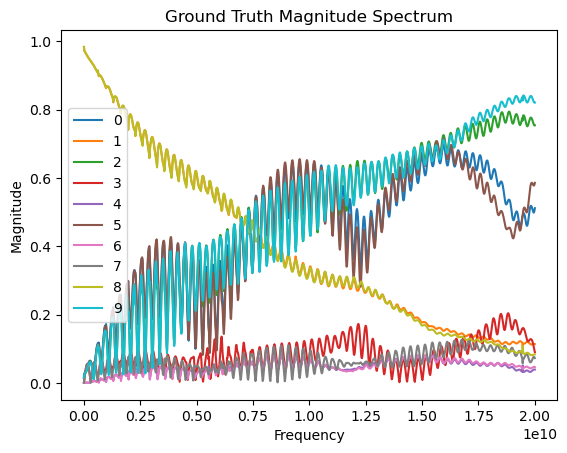

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

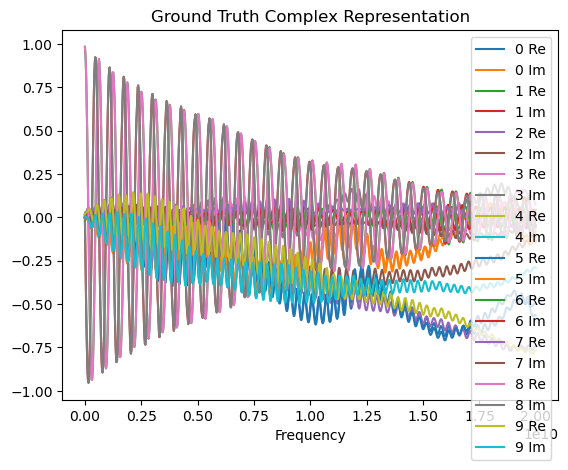

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 2

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)

Number of Ground Truth Frequency Points:  1000
Number of Measurements:  2
Undersampling Ratio:  0.002
[  0 999]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 2])
y_freqs shape:  (2,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Net output shape:  torch.Size([1, 20, 1000])


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = 130

LR = 2e-4
NUM_ITER = 2000
TOTAL_ITERS = NUM_ITER * (NUM_ACTIVE + 1)
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1][-1], pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        print(x.shape)
        print(outputs.shape)
        abs_differences = torch.square(torch.subtract(x[0], outputs))

        # Sum to go to [1000]
        abs_differences = torch.mean(abs_differences, dim=0)
        print(abs_differences)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(abs_differences) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(abs_differences, len(abs_differences))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  4.940043926239014
NOISE LEVEL:  0.9999736348694022

ITER  999
TIME:  34.3262665271759
NOISE LEVEL:  0.9739790564742055

ITER  1999
TIME:  69.51649117469788
NOISE LEVEL:  0.9486352024503846

NUM_SAMPLES  0
TIME:  69.51649117469788
torch.Size([1, 20, 1000])
torch.Size([20, 1000])
tensor([0.0711, 0.0704, 0.0721, 0.0747, 0.0785, 0.0834, 0.0889, 0.0946, 0.1002,
        0.1053, 0.1102, 0.1150, 0.1190, 0.1221, 0.1240, 0.1245, 0.1237, 0.1220,
        0.1189, 0.1150, 0.1106, 0.1056, 0.1000, 0.0939, 0.0882, 0.0827, 0.0778,
        0.0740, 0.0705, 0.0669, 0.0636, 0.0626, 0.0616, 0.0618, 0.0636, 0.0660,
        0.0696, 0.0741, 0.0796, 0.0859, 0.0922, 0.0983, 0.1040, 0.1089, 0.1125,
        0.1144, 0.1145, 0.1132, 0.1101, 0.1068, 0.1034, 0.0990, 0.0942, 0.0894,
        0.0851, 0.0811, 0.0770, 0.0734, 0.0702, 0.0674, 0.0648, 0.0623, 0.0603,
        0.0585, 0.0571, 0.0561, 0.0572, 0.0585, 0.0615, 0.0658, 0.0714, 0.0782,
        0.0853, 0.0923, 0.0981, 0.1029, 0.1058, 0.1078, 0.1086, 0.

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([5, 20, 1000])
torch.Size([20, 1000])
torch.Size([20, 1000])


## Plot metrics and outputs

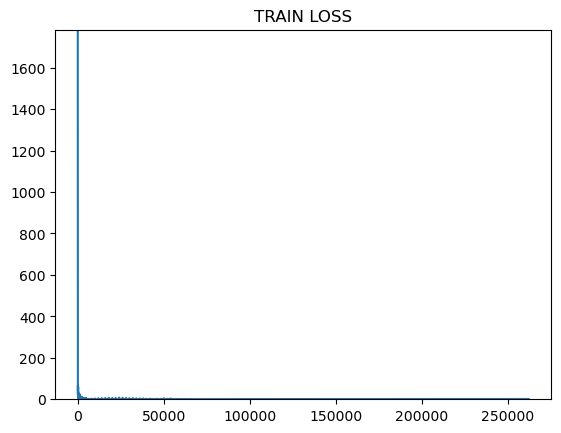

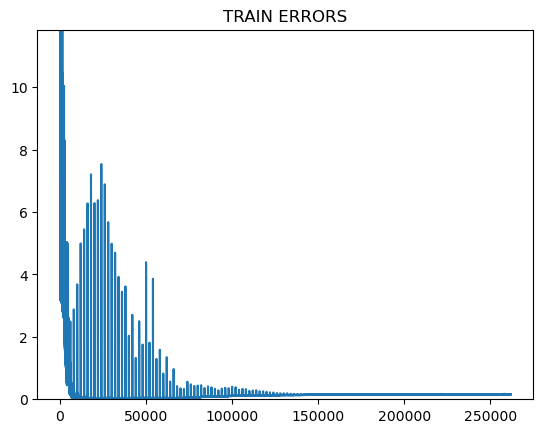

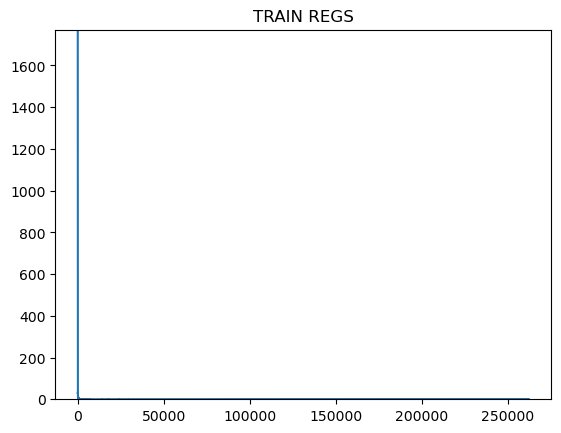

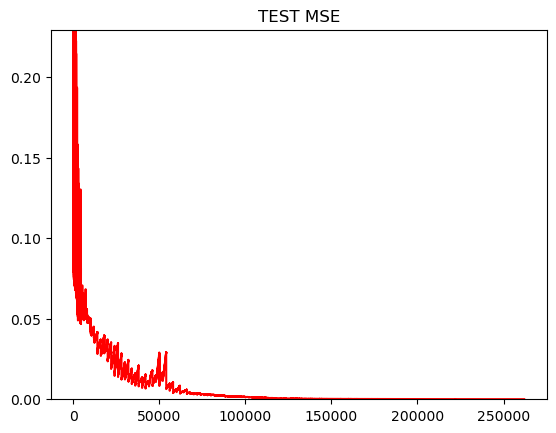

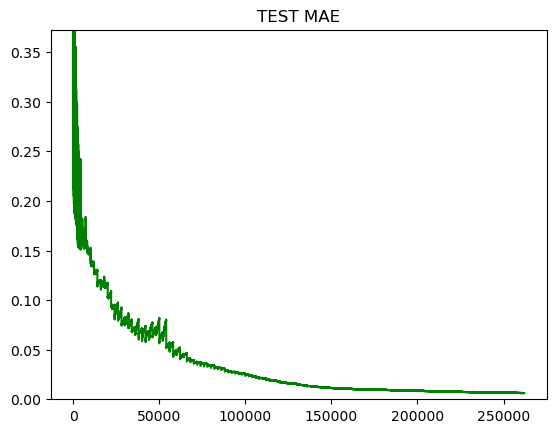

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  7.174870552262291e-05
Best Test MSE:  6.933155964361504e-05
Best Test MSE Iteration:  260910


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case09/case09.s4p
[1.00000000e+01 2.00200300e+07 1.60160170e+08 3.20320330e+08
 5.00500510e+08 7.00700710e+08 9.00900910e+08 1.14114115e+09
 1.34134135e+09 1.48148149e+09 1.60160161e+09 1.72172173e+09
 1.82182183e+09 1.96196197e+09 1.98198199e+09 2.10210211e+09
 2.20220221e+09 2.30230231e+09 2.36236237e+09 2.46246247e+09
 2.64264265e+09 2.74274275e+09 2.86286287e+09 2.90290291e+09
 2.98298299e+09 3.10310311e+09 3.24324325e+09 3.30330331e+09
 3.38338339e+09 3.56356357e+09 3.60360361e+09 3.64364365e+09
 3.74374375e+09 3.86386387e+09 3.94394395e+09 4.04404405e+09
 4.16416417e+09 4.22422423e+09 4.30430431e+09 4.44444445e+09
 4.54454455e+09 4.66466467e+09 4.86486487e+09 4.96496497e+09
 5.12512513e+09 5.22522523e+09 5.34534535e+09 5.48548549e+09
 5.58558559e+09 5.72572573e+09 5.80580581e+09 5.84584585e+09
 6.00600601e+09 6.12612613e+09 6.22622623e+09 6.34634635e+09
 6.40640641e+09 6.52652653e+09 6.64664665e+09 6.74674675e+09
 6.86686687e+09 7.027

/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 262518952870526.12). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: R

  Fitting took 3.6560557410120964 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.15034992061555386 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 was not subtantially better than 2 (err 1.5228252867699112 vs 1.2372921402170651)
Performing fit with 3 poles.


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 262663133577298.62). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.36257388442754745 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.7966552126538549 vs 1.2372921402170651)
Performing fit with 4 poles.


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 262782732814396.22). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.28906230069696903 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 2 (err 1.1536875354786944 vs 1.2372921402170651)
Performing fit with 5 poles.
  Fitting took 0.2983521334826946 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 1.0240710413592902 vs 1.1536875354786944)
Performing fit with 6 poles.


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 263043821973060.38). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.4216593634337187 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 1.3758938383262016 vs 1.0240710413592902)
Performing fit with 7 poles.
  Fitting took 0.8731516785919666 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 6 (err 1.0054085219505453 vs 1.0240710413592902)
Performing fit with 8 poles.
  Fitting took 0.5219165924936533 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 poles better than 8 (err 0.9347845394167325 vs 1.0054085219505453)
Performing fit with 9 poles.
  Fitting took 0.6001730151474476 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 10 was not subtantially better than 9 (err 1.0035002647951161 vs 0.9347845394167325)
Performing fit with 10 poles.
  Fitting took 0.7134095299988985 seconds.
  Filling sam

/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 363437885824217.56). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.9146968778222799 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 13 poles better than 11 (err 0.431460898280175 vs 0.5997841600636821)
Performing fit with 13 poles.
  Fitting took 0.7537563554942608 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 14 was not subtantially better than 13 (err 0.5937395311570953 vs 0.431460898280175)
Performing fit with 14 poles.


/u/bodeng/CurveFitting-DIP/oracle_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 361221106729788.75). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 1.907591251656413 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 15 was not subtantially better than 13 (err 0.7712722944963839 vs 0.431460898280175)
Performing fit with 15 poles.
  Fitting took 2.088122647255659 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 16 was not subtantially better than 13 (err 0.482877129958833 vs 0.431460898280175)
Fit completed in 17.679485082626343, using 15, resulting in a fit with 13 and error=0.431460898280175 vs samples and error=0.43442259145695267 vs ground truth.
(1000, 4, 4)
complex128
torch.Size([1, 20, 1000])


In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1000, 4, 4, 2])
torch.Size([1000, 4, 4, 2])
torch.Size([132, 4, 4, 2])
(1000, 4, 4, 2)
(1000, 4, 4, 2)
(10, 2, 1000)
(10, 2, 1000)
float32
float32
DIP PSNR:       47.46245881216229
VF PSNR:        25.924822676801327
Final DIP MSE:  7.174870552262291e-05
VF MSE:         0.010222984477877617
Mean DIP MSE:  7.11814354872331e-05


(1000,)
torch.Size([20, 1000])
torch.Size([1, 20, 1000])
torch.Size([1, 20, 132])
torch.Size([1, 20, 1000])
torch.Size([1, 20, 1000])


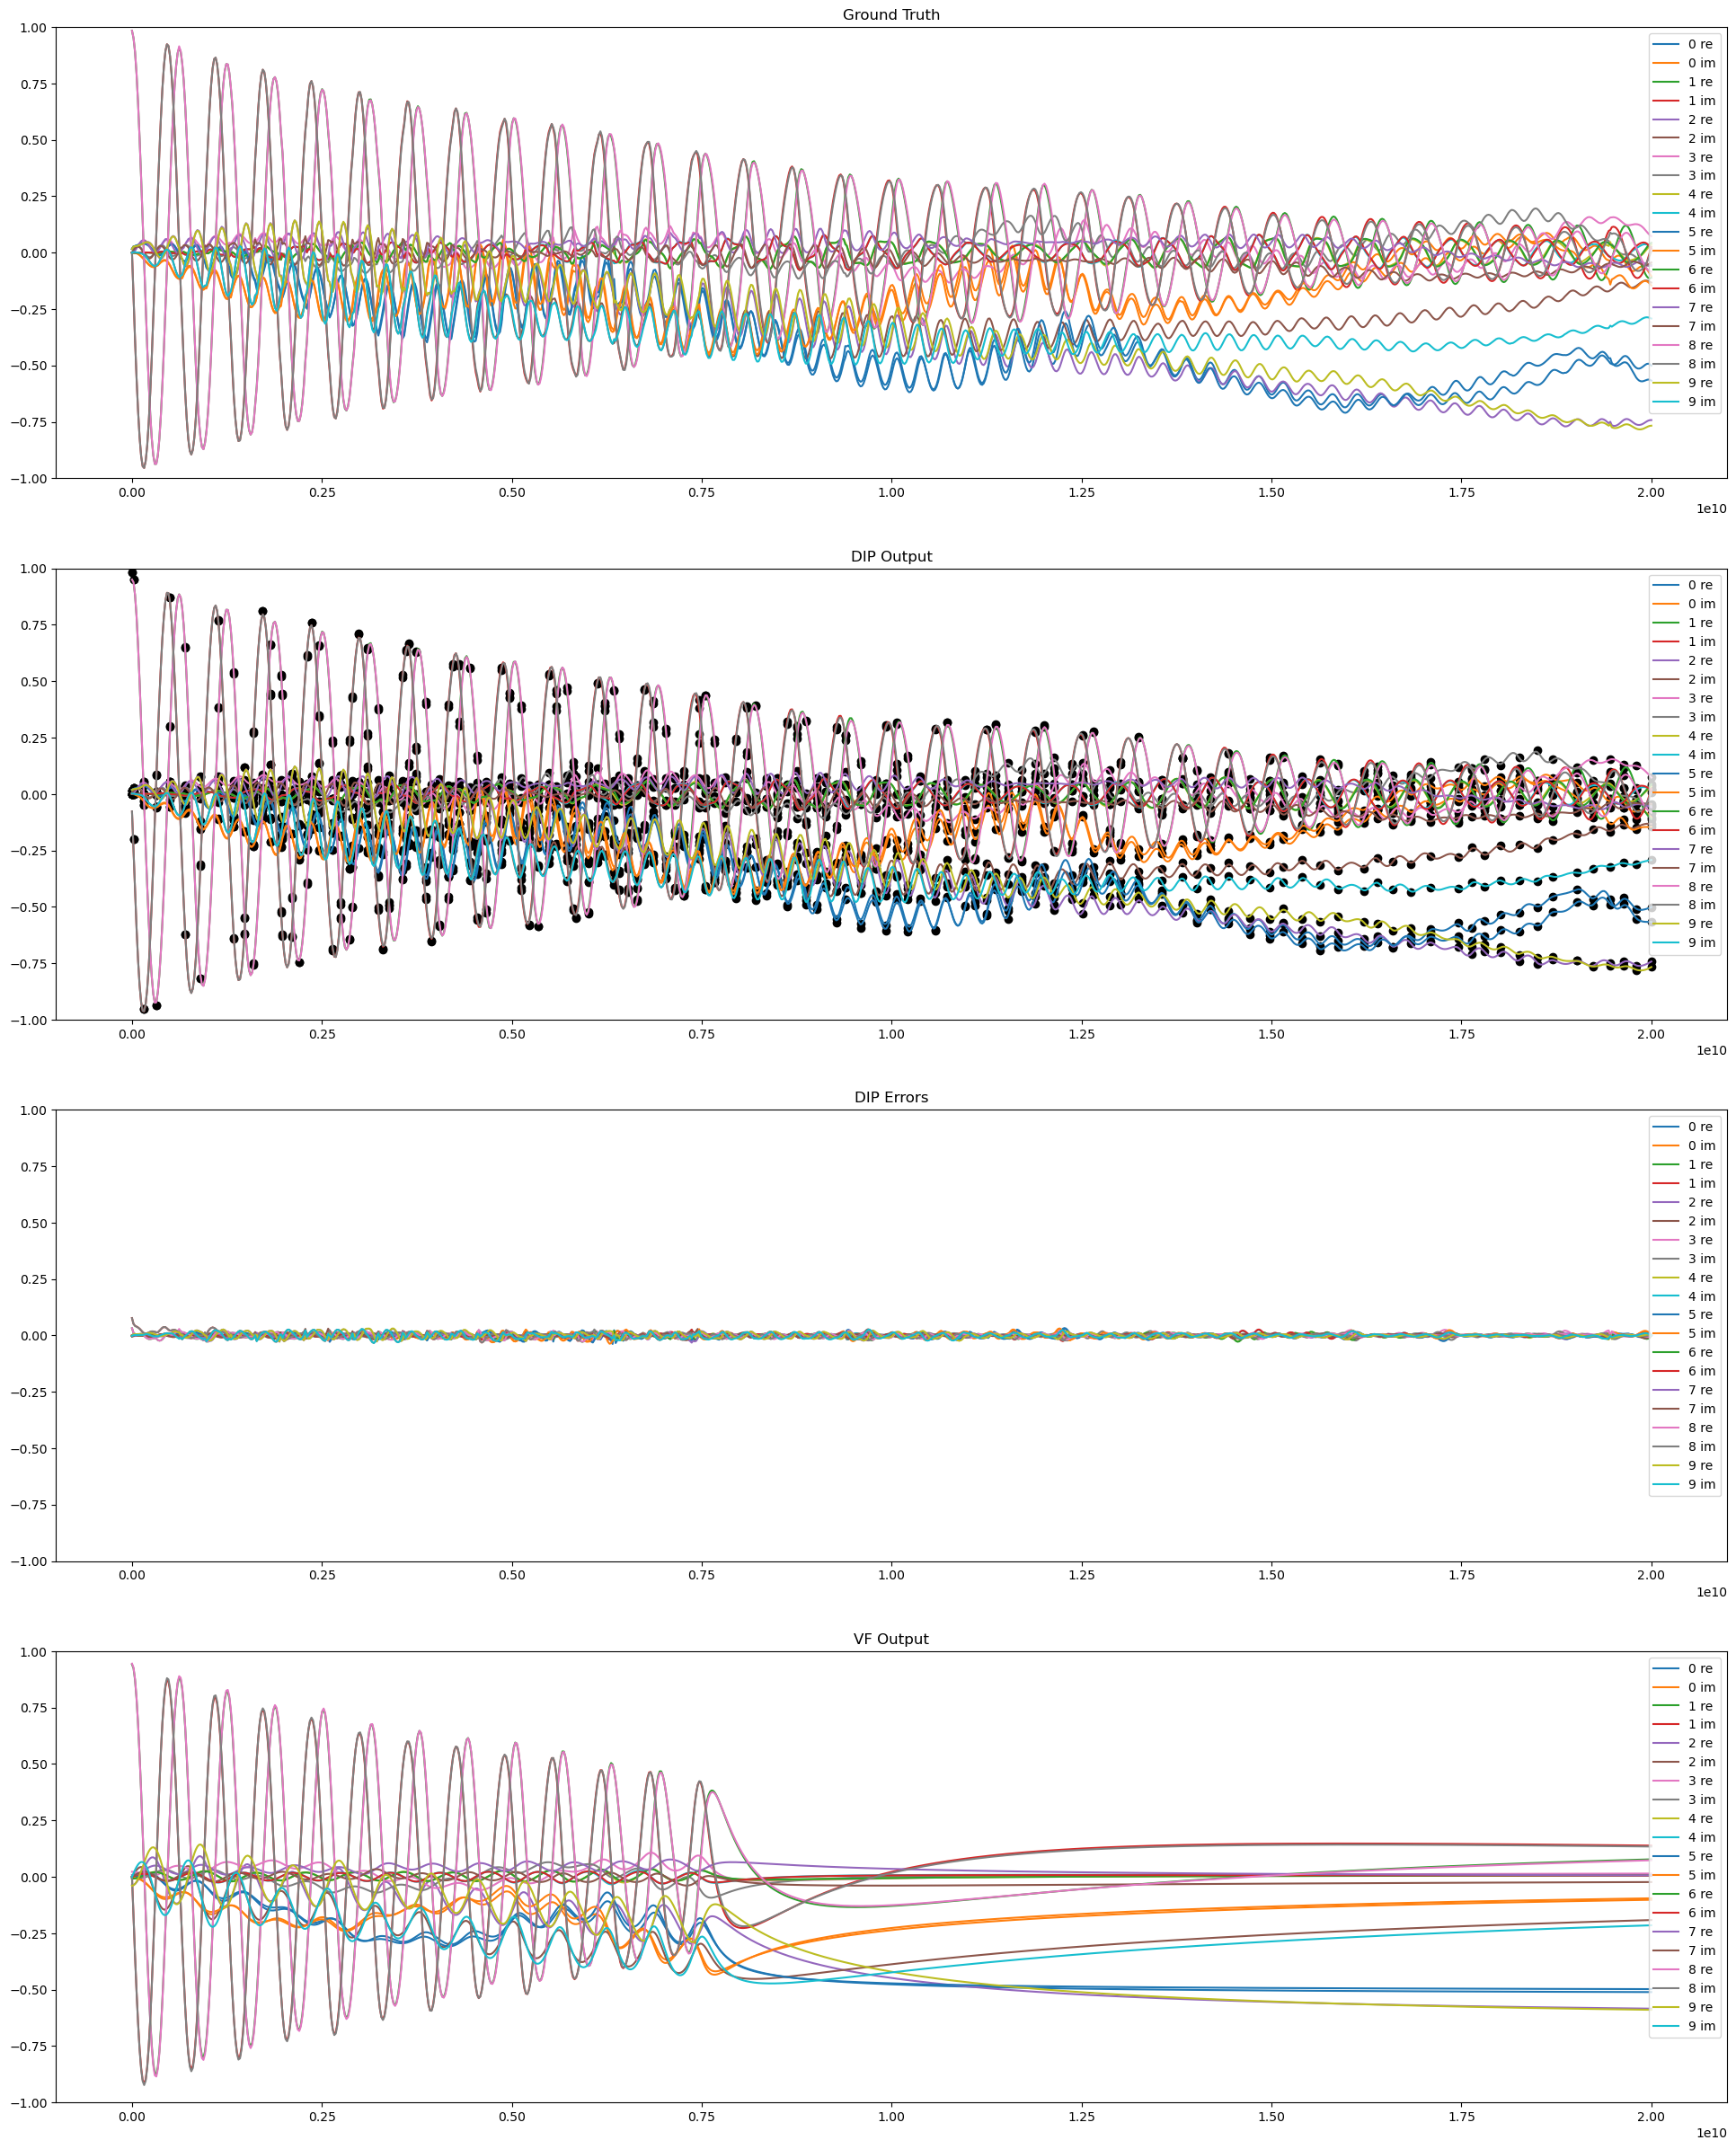

In [33]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[2.7899e-04, 2.1674e-04, 2.1985e-04, 2.1615e-04, 2.0463e-04, 1.9672e-04,
         2.4146e-04, 2.2960e-04, 2.2479e-04, 2.1246e-04, 2.2765e-04, 2.4944e-04,
         2.5551e-04, 2.5498e-04, 2.5040e-04, 2.4597e-04, 2.5921e-04, 3.3696e-04,
         3.1928e-04, 3.0309e-04, 3.0224e-04, 2.9340e-04, 2.7965e-04, 2.6646e-04,
         2.7138e-04, 2.8865e-04, 2.9789e-04, 2.8929e-04, 2.8358e-04, 2.7246e-04,
         2.7849e-04, 2.7124e-04, 2.5859e-04, 2.4175e-04, 2.3750e-04, 2.2962e-04,
         2.3520e-04, 2.1883e-04, 1.8809e-04, 1.9100e-04, 2.0246e-04, 2.1949e-04,
         2.4437e-04, 1.8295e-04, 1.8954e-04, 1.9698e-04, 2.5867e-04, 2.4681e-04,
         2.5268e-04, 2.3710e-04, 2.4370e-04, 2.3759e-04, 2.2361e-04, 2.1812e-04,
         2.0738e-04, 2.1781e-04, 2.4265e-04, 2.7811e-04, 3.2404e-04, 3.3707e-04,
         3.4473e-04, 3.4782e-04, 3.3053e-04, 2.9845e-04, 2.8132e-04, 2.5386e-04,
         2.5353e-04, 2.4121e-04, 2.3026e-04, 2.1708e-04, 2.2540e-04, 2.2708e-04,
         2.2159e-04, 1.9626e

In [30]:
print(dip_errors[-1])

tensor([[-2.4669e-03,  5.0608e-03,  4.5233e-03,  4.7764e-03,  5.3599e-03,
          5.1995e-03,  4.9885e-03,  4.3178e-03,  3.7176e-03,  4.2362e-03,
          5.4064e-03,  6.4364e-03,  6.6804e-03,  5.5394e-03,  4.0479e-03,
          2.0078e-03,  7.9470e-04, -1.3360e-03, -1.7975e-03, -1.1902e-03,
         -2.8591e-04,  1.4066e-03,  4.5005e-03,  4.5851e-03,  5.4446e-03,
          5.6666e-03,  6.6027e-03,  7.6942e-03,  8.2666e-03,  7.7288e-03,
          5.8226e-03,  4.1819e-03,  2.3238e-03, -1.5268e-03, -5.8376e-03,
         -4.8683e-03, -4.7823e-03, -3.6525e-03,  1.0448e-04,  4.6004e-03,
          8.9332e-03,  1.1898e-02,  1.2993e-02,  1.1644e-02,  9.1107e-03,
          6.1825e-03,  4.2034e-03,  1.5837e-03,  2.9433e-03, -1.1752e-02,
         -1.3850e-02, -1.2919e-02, -9.8908e-03, -4.9180e-03,  6.9641e-04,
          5.5642e-03,  8.8586e-03,  9.9270e-03,  1.1701e-02,  1.3263e-02,
          1.3293e-02,  1.1388e-02,  7.9946e-03,  4.8564e-03,  4.2449e-03,
         -7.2540e-03, -1.0723e-02, -8.

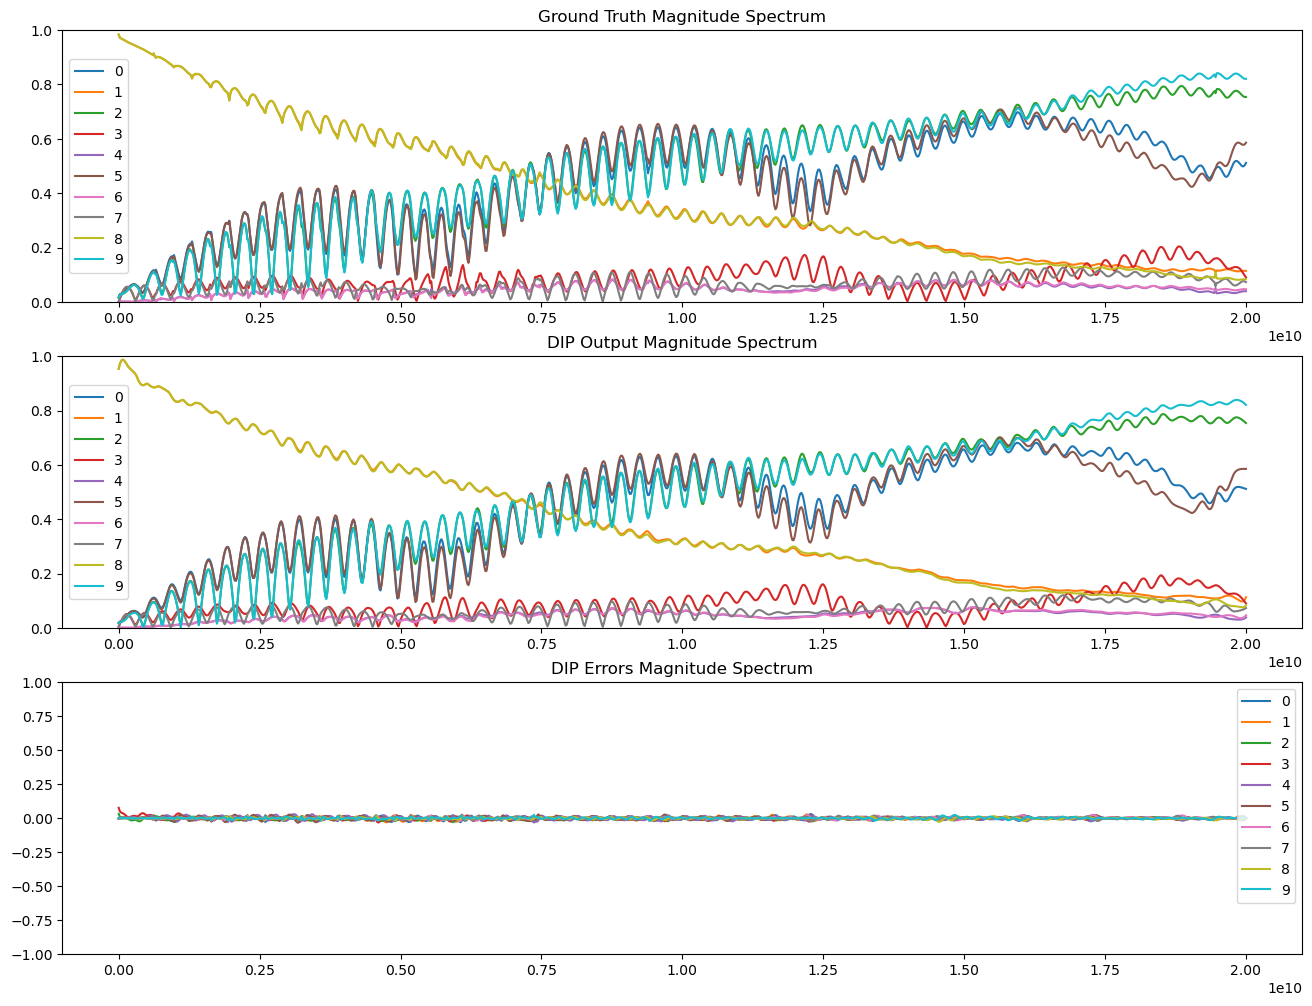

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[  0   1   8  16  25  35  45  57  67  74  80  86  91  98  99 105 110 115
 118 123 132 137 143 145 149 155 162 165 169 178 180 182 187 193 197 202
 208 211 215 222 227 233 243 248 256 261 267 274 279 286 290 292 300 306
 311 317 320 326 332 337 343 351 357 363 373 377 383 390 397 404 410 417
 424 431 437 443 450 456 463 469 479 489 496 503 510 518 528 536 548 554
 562 568 576 585 594 600 606 618 625 632 643 650 662 677 691 700 709 721
 735 748 757 769 781 793 810 819 829 841 854 872 881 889 900 912 924 934
 950 961 972 981 989 999]
